*UCSB MEDS* - *EDS 220 - Working With Environmental Datasets in Python*

# Pheonix Biodiversity Intactness Index Analysis
### Mapping ......

![Python](https://img.shields.io/badge/Python-cornflowerblue?style=for-the-badge&logo=R) ![Remote Sensing](https://img.shields.io/badge/Remote_Sensing-green?style=for-the-badge) ![GIS](https://img.shields.io/badge/GIS-purple?style=for-the-badge)  ![UCSB MEDS](https://img.shields.io/badge/UCSB%20MEDS-blue?style=for-the-badge) 

**Author:** Nicole Pepper

<div style="text-align: left;">
  <img src="images/houston-lights.jpg" alt="Image" width="900">

### About the Repo:
This notebook investigates the impacts of urban expansion by analyzing a dataset that captures values for the [Biodiversity Intactness Index (BII)](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf). [In 2021, Maricopa County —home to the Phoenix metropolitan area— was identified as the U.S. county with the most significant increase in developed land since 2001](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/). This rapid urban sprawl has profound implications for biodiversity and the health of surrounding natural ecosystems. I examine changes in BII in the Phoenix county subdivision area between 2017 and 2020, shedding light on how urban growth affects biodiversity over time.

### Technical Highlights:
- Programming in Python using `Jupyter Lab`
- Data retreival from Microsoft STAC catalog with `pystac_client`
- Vector data wrangling with `gpd`
- Raster data wrangling with `rioxarray` and `xarray`
- Data visualization with `matplotlib`
- Creating a map gif with `geogif`
    
### Data Descriptions:

- The `Biodiversity Intactness Index (BII) Time Series` data is a collection of ...... It is from ..... I accessed the data using the `io-biodviersity` collection from the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). I use the 2017 and 2020 rasters covering the Pheonix subdivision.

- The `Pheonix Subdivision Shapefile` data is a shapefile containing the perimeters of the Pheonix metro area. It is a subset of the Census County Subdivision shapefiles for Arizona. The data is a subset of Census County Subdivision shapefiles from the [U.S. Census Bureau](https://www.census.gov/programs-surveys/acs) from 2020 for Arizona. I accessed it on the [U.S. Census Bureau website](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions).

# 1. Set Up Workspace

### 1a. Load libraries

In [3]:
# ---- Load libraries ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 
from IPython.display import Image  # To nicely display images
from geogif import gif
from shapely.geometry import box
import xarray as xr
import os
from IPython.display import Image, display, HTML # for visualizing images

### 1b. Read in Project Data

In [5]:
# ----- Read in Phoenix subdivision boundary ------

# Read in Arizona subdivisions data
arizona_sds = gpd.read_file("data/tl_2020_04_cousub.shp")

# Subset to phoenix
phoenix = arizona_sds[arizona_sds['NAME'] == 'Phoenix']


In [6]:
# ----- Read in bii data ------

# Define Pheonix bbox

bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# ----- Access MPC catalog ------

# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Access MPC collections as a list
catalog.get_collections()
collections = list(catalog.get_collections())


# Define temporal range for 2017 and 2020
time_ranges = ["2017-01-01/2017-12-31", "2020-01-01/2020-12-31"]

# Initialize an empty list to collect items
items = []

# Define for loop to iterate search for both time ranges
for time_range in time_ranges:
    search = catalog.search(
        collections=["io-biodiversity"],
        bbox=bbox,
        datetime=time_range
    )
    items.extend(list(search.items()))

# Print summary of found items
print(f"Found {len(items)} items matching the criteria.")

# Separate 2017 and 2020 images    
phoenix_2017_item = items[0]
phoenix_2020_item = items[1]

print(phoenix_2017_item.id)
print(phoenix_2020_item.id)

# ---- Retreive BII data from items ----

# Get 2017 Phoenix data
phoenix_2017 = phoenix_2017_item.assets["data"]

phoenix_2017 = rioxr.open_rasterio(phoenix_2017.href)

# Get 2020 Phoenix data

phoenix_2020 = phoenix_2020_item.assets["data"]

phoenix_2020 = rioxr.open_rasterio(phoenix_2020.href)

Found 2 items matching the criteria.
bii_2017_34.74464974521749_-115.38597824385106_cog
bii_2020_34.74464974521749_-115.38597824385106_cog


# 2. Prepare and Explore Preliminary Data

### 2a. Check CRS

In [8]:
# ---- Check CRS ----

# Set CRS to WGS 84 to match MPC data
phoenix = phoenix.to_crs("EPSG:4326")

# Print the crs name 
print("The BII CRS is:", phoenix_2017.rio.crs)

# Print the crs name
print("The phoenix CRS is:", phoenix.crs.name)

The BII CRS is: EPSG:4326
The phoenix CRS is: WGS 84


### 2b. Clip BII data to the Phoenix boundary

In [9]:
# ---- Clip BII to Phoenix boundary ----
phoenix_2017_clipped = phoenix_2017.rio.clip(phoenix.geometry, phoenix.crs, drop=True)
phoenix_2020_clipped = phoenix_2020.rio.clip(phoenix.geometry, phoenix.crs, drop=True)

### 2c. Visualize Preliminary Phoenix Subdivision Data

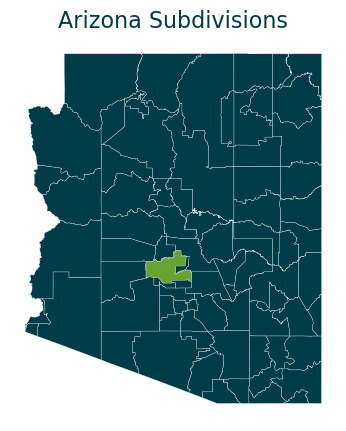

In [11]:
# ---- Map Arizona Subdivisions ----

# Set figure parameters
fig, ax = plt.subplots(figsize=(5, 5))

# Plot arizona subdivisions
arizona_sds.plot(ax=ax, color='#003B4A', edgecolor='white', linewidth = 0.2)

# Plot phoenix subdivision
phoenix.plot(ax=ax, color='#67A32F', edgecolor='white', linewidth = 0.2)

# Remove axes
ax.axis('off')

# Add a title and display the plot
plt.title("Arizona Subdivisions", fontsize=16, color='#003B4A')
plt.show()

### 2d. Visualize Preliminary Phoenix Subdivision Data

In [12]:
# Define URLs for the 2017 and 2020 images
phoenix_2017_url = phoenix_2017_item.assets['rendered_preview'].href
phoenix_2020_url = phoenix_2020_item.assets['rendered_preview'].href

# Display images for 2017 and 2020 next to eachother
display(HTML(f"""
    <div style="display: flex; justify-content: space-between; align-items: center; gap: 20px;">
        <div style="text-align: center;">
            <p><strong>Phoenix BII 2017</strong></p>
            <img src="{phoenix_2017_url}" width="400" />
        </div>
        <div style="text-align: center;">
            <p><strong>Phoenix BII 2020</strong></p>
            <img src="{phoenix_2020_url}" width="400" />
        </div>
    </div>
"""))


# 3. Calculate the Percentage of Area of the Phoenix Subdivision with a BII of at least 0.75 for 2017 and 2018

### 3a. Reclassify Data for Threshold Where *BII > 0.75*

In [13]:
# ---- Reclassify data ----
def reclassify_data(data, threshold):
    reclassified = xr.where(data > threshold, 1, 0)
    return reclassified

# Reclassify data for 2017 and 2020
phoenix_2017_reclassified = reclassify_data(phoenix_2017_clipped.sel(band=1), 0.75)
phoenix_2020_reclassified = reclassify_data(phoenix_2020_clipped.sel(band=1), 0.75)

2017 Value Counts: {0: 553037, 1: 24133}
2020 Value Counts: {0: 555184, 1: 21986}


### 3b. Calculate Percent Area for 2017 & 2020

In [ ]:
# ---- Value Counts ----
values_2017, counts_2017 = np.unique(phoenix_2017_reclassified.values, return_counts=True)
values_2020, counts_2020 = np.unique(phoenix_2020_reclassified.values, return_counts=True)

print("2017 Value Counts:", dict(zip(values_2017, counts_2017)))
print("2020 Value Counts:", dict(zip(values_2020, counts_2020)))

# 4. Create a Map that Highlights Regions Where BII > 0.75 in 2017 Were Lost By 2020

### 4a. Find Where 2017 *BII > 0.75* Was Lost By 2020

### 4b. Map Where 2017 *BII > 0.75* Was Lost By 2020